# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

_Описание данных_

__Признаки__
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя


__Целевой признак__
* `Price` — цена (евро)

##  Подготовка данных

In [1]:
#импортируем библиотеки

import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import time

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

from category_encoders import MEstimateEncoder

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import warnings

warnings.filterwarnings('ignore')

In [2]:
#считаем файл с данными и сохраним в датафрейм

pth1 = 'C:/Users/ACER/Desktop/Практикум/project/datasets/autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
else:
    data = pd.read_csv(pth2)
    

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data_length = data.shape[0]
data_length

354369

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
 data.sort_values(by='DateCrawled', ascending=False).head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90713,2016-04-07 14:36:58,3500,sedan,1999,manual,143,e_klasse,150000,8,gasoline,mercedes_benz,no,2016-04-07 00:00:00,0,64846,2016-04-07 14:36:58
339649,2016-04-07 14:36:56,8650,suv,1992,manual,121,wrangler,125000,5,petrol,jeep,no,2016-04-07 00:00:00,0,20357,2016-04-07 14:36:56
301030,2016-04-07 14:36:55,15200,wagon,2008,manual,190,a6,150000,9,gasoline,audi,no,2016-04-07 00:00:00,0,81476,2016-04-07 14:36:55
53739,2016-04-07 14:36:54,400,small,1996,manual,60,ibiza,150000,0,NaN,seat,NaN,2016-04-07 00:00:00,0,66299,2016-04-07 14:36:54
204218,2016-04-07 14:36:53,6990,coupe,1979,auto,143,3er,150000,6,petrol,bmw,no,2016-04-07 00:00:00,0,71336,2016-04-07 14:36:53


Последние данные выгружены в базу в апреле 2016 года.

Столбцы с признаками `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` являются неинформативными и усложняют обучение, удалим их.

In [7]:
list_columns = (['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'])
data = data.drop(list_columns, axis=1)
print('Количество столбцов:', data.shape[1])

Количество столбцов: 10


In [8]:
#проверим на наличие строк-дубликатов

data.duplicated().sum()

45040

In [9]:
#удалим дубликаты

data = data.drop_duplicates().reset_index(drop=True)
data.shape

(309329, 10)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309329 entries, 0 to 309328
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             309329 non-null  int64 
 1   VehicleType       274770 non-null  object
 2   RegistrationYear  309329 non-null  int64 
 3   Gearbox           292122 non-null  object
 4   Power             309329 non-null  int64 
 5   Model             290968 non-null  object
 6   Kilometer         309329 non-null  int64 
 7   FuelType          278565 non-null  object
 8   Brand             309329 non-null  object
 9   Repaired          244771 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


In [11]:
#проверим на наличие аномальных значений

data.describe()

,Price,RegistrationYear,Power,Kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


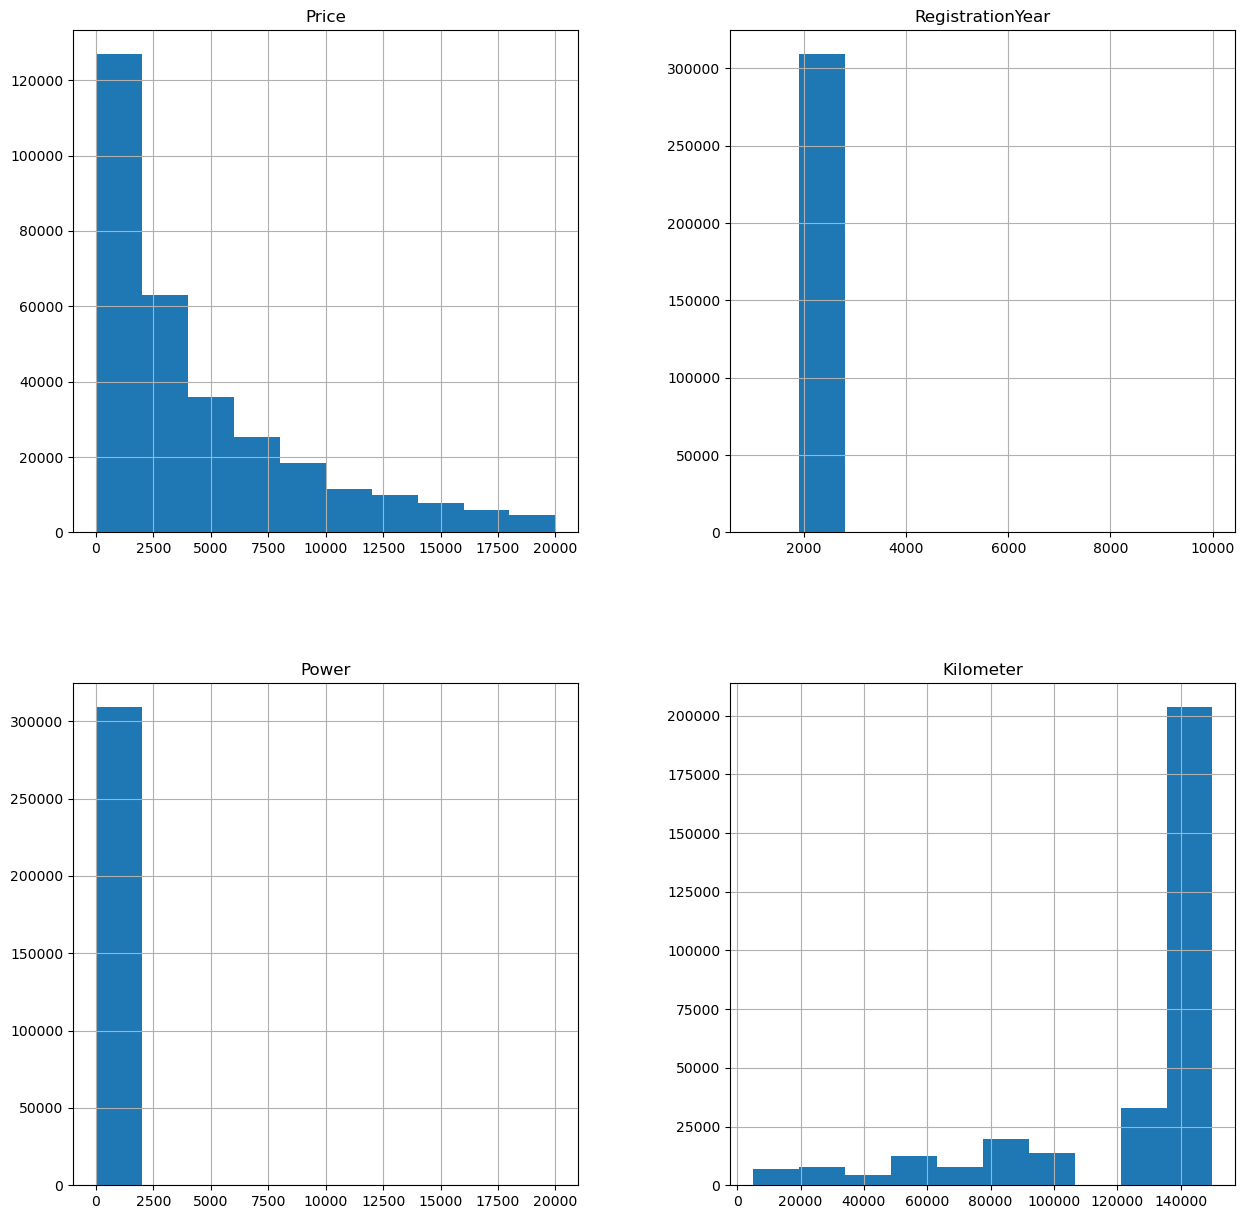

In [12]:
data.hist(figsize=(15, 15))
plt.show()

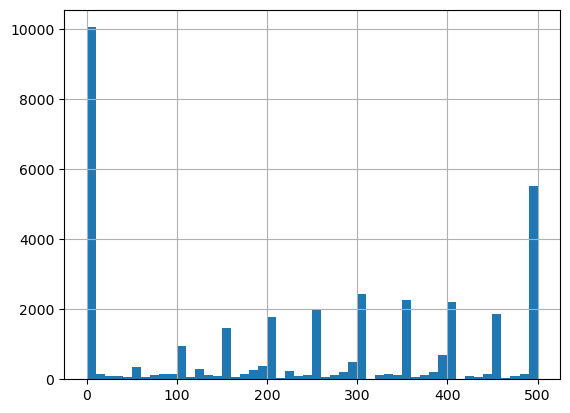

In [13]:
data['Price'].hist(bins=50, range=(0, 500))
plt.show()

In [14]:
#удалим значения в столбце `Price`, не превышающие 100 евро

data = data.loc[data['Price'] >= 100]

In [15]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936,
       1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928,
       5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500, 1602,
       7800, 1947, 1927, 7100, 8200, 1946], dtype=int64)

Удалим данные в столбце `RegistrationYear`, не входящие в промежуток от 1900 до 2016 года (год скачивания анкет в базу)

In [16]:
data = data.loc[(data['RegistrationYear'] < 2017) & (data['RegistrationYear'] > 1900)]

In [17]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980, 1970, 1965,
       1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1966,
       1975, 1963, 1964, 1960, 1958, 1967, 1956, 1941, 1962, 1929, 1957,
       1940, 1949, 1937, 1951, 1959, 1953, 1954, 1950, 1948, 1952, 1932,
       1942, 1935, 1933, 1936, 1923, 1930, 1944, 1943, 1938, 1934, 1928,
       1931, 1947, 1927, 1946], dtype=int64)

In [18]:
data['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,    60,   136,   160,   231,    50,
         118,   193,    99,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   232,   150,   156,
          80,    82,    90,   155,    54,   185,    87,   180,    86,
          84,   224,   235,   200,   178,   265,    77,   110,   144,
         120,   286,   116,   184,   126,   204,    88,   194,    64,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    73,   192,    68,    66,   299,    74,
          52,   147,   310,    71,    97,    65,   239,   203,     5,
         300,   103,    85,   258,   320,    63,    81,   148,    44,
         145,   280,   260,   104,   188,   333,   186,   117,   141,
         132,   234,   158,    39,    92,    51,   135,    59,   230,
         209,    43,

Заменим данные в столбце `Power` в зависимости от величины значения

In [19]:
def power(power):
    if power < 1000:
        return power
    elif 1000 <= power < 10000:
        return power // 10
    else:
        return power // 100

data['Power'] = data['Power'].apply(power)    

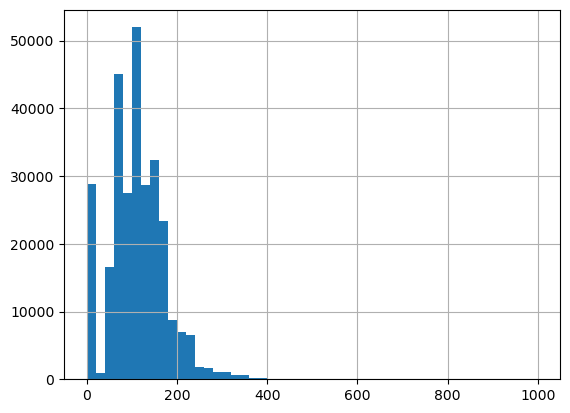

In [20]:
data['Power'].hist(bins=50)
plt.show()

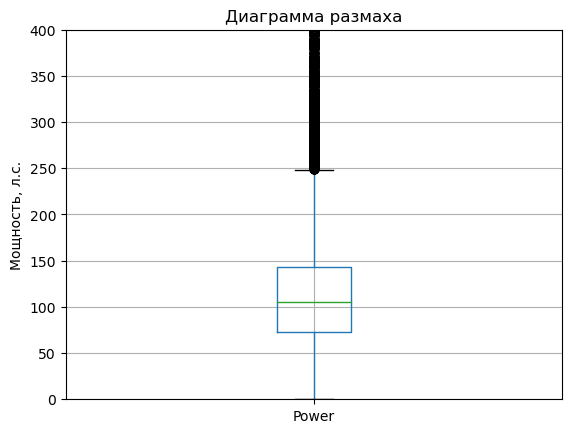

In [21]:
data.boxplot(column='Power')
plt.title('Диаграмма размаха')
plt.ylabel('Мощность, л.с.')
plt.ylim(0, 400)
plt.grid(True)
plt.show()

In [22]:
#удалим значения в столбце `Power`, превышающие 250 л.с.

data = data.loc[data['Power'] < 250]

Пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` заменим на _unknown_

In [23]:
data[['VehicleType', 'Gearbox', 'Model', 'FuelType']] = (data[['VehicleType', 'Gearbox', 'Model', 'FuelType']]
                                                         .fillna('unknown'))

Пропуски в столбце `Repaired` заменим на _no_

In [24]:
data['Repaired'] = data['Repaired'].fillna('no')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278328 entries, 0 to 309328
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             278328 non-null  int64 
 1   VehicleType       278328 non-null  object
 2   RegistrationYear  278328 non-null  int64 
 3   Gearbox           278328 non-null  object
 4   Power             278328 non-null  int64 
 5   Model             278328 non-null  object
 6   Kilometer         278328 non-null  int64 
 7   FuelType          278328 non-null  object
 8   Brand             278328 non-null  object
 9   Repaired          278328 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.4+ MB


In [26]:
data_length_upd = data.shape[0]
#((data_length - data_length_upd) / data_length) * 100
print('Из датасета исключено', round(((data_length - data_length_upd) / data_length) * 100, 2),'процентов данных')

Из датасета исключено 21.46 процентов данных


In [27]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.438854,0.447944,-0.369711
RegistrationYear,0.438854,1.000000,0.167069,-0.215877
Power,0.447944,0.167069,1.000000,0.093562
Kilometer,-0.369711,-0.215877,0.093562,1.000000


__Вывод__

Данные в датасете соответствуют описанию. \
Столбцы с признаками `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` определены как неинформативные и удалены. \
Также из датасета исключены строки-дубликаты. \
Аномальные значения в столбце `RegistrationYear` удалены, в столбце `Power` приведены к единому классу, также исключены данные, превышающие значение 250 л.с. \
Заполнить пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` не представляется возможным, поэтому сделана замена на _unknown_. В столбце `Repaired` скорее всего отсутствуют данные по автомобилям, которые не были в ремонте, поэтому сделана замена на _no_. \
Из датасета исключено более 21% данных, 13% из которых пришлось на строки-дубликаты.

В данных наблюдаются слабые зависимости стоимости автомобиля от мощности двигателя и года выпуска (положительная зависимость), отрицательная от пробега.

Целевой признак представлен численным значением, будем решать задачу регрессии обучением с учителем.

## Обучение моделей

In [28]:
#разделим выборки на признаки (X) и целевую переменную (y)

X = data.drop(columns=['Price'], axis = 1)
y = data['Price']

In [29]:
#разделим данные на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [30]:
display(X_train.shape)
display(X_test.shape)

(208746, 9)

(69582, 9)

In [31]:
data['Brand'].value_counts().count()

40

In [32]:
data['Model'].value_counts().count()

250

In [33]:
#преобразуем категориальные переменные в столбцах Brand и Model в численные с помощью MEstimateEncoder

feature_list = ['Model', 'Brand']
MEE_encoder = MEstimateEncoder(cols=feature_list, m=5.0)
X_train[feature_list] = MEE_encoder.fit_transform(X_train[feature_list], y_train)
X_test[feature_list] = MEE_encoder.transform(X_test[feature_list])
display(X_train.shape)
X_train.head(20)

(208746, 9)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
165869,small,2004,auto,61,3718.166066,100000,petrol,3623.513087,no
95537,sedan,1992,auto,150,1511.807673,150000,petrol,6381.504895,no
75169,bus,2005,manual,150,3762.556451,150000,gasoline,3319.620077,no
179424,suv,2005,manual,109,3129.822970,150000,gasoline,7917.668866,no
136069,wagon,2000,auto,230,6479.831679,150000,petrol,6381.504895,no
27726,sedan,1990,manual,122,3129.822970,150000,petrol,5842.783613,no
105916,small,1994,manual,40,1833.847673,150000,petrol,4133.476269,yes
91975,bus,2008,manual,175,3762.556451,20000,gasoline,3319.620077,no
143958,sedan,2007,auto,95,3561.299411,80000,petrol,5842.783613,no
103251,bus,1994,manual,77,6948.828247,150000,gasoline,4738.987271,no


In [34]:
#категориальные переменные в столбцах VehicleType, Gearbox, FuelType, Repaired в численные кодируем OneHotEncoder

cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
encoder = OneHotEncoder(sparse = False, drop='first')
X_train_ohe = pd.DataFrame(encoder.fit_transform(X_train[cat_features]))
X_test_ohe = pd.DataFrame(encoder.transform(X_test[cat_features]))
display(X_train_ohe.shape)
X_train_ohe.head()

(208746, 18)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
#масштабируем численные признаки

pd.options.mode.chained_assignment = None
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'Model', 'Brand']
scaler = StandardScaler()
X_train_scaler = pd.DataFrame(scaler.fit_transform(X_train[numeric]))
X_test_scaler = pd.DataFrame(scaler.transform(X_test[numeric]))
display(X_train_scaler.shape)
X_train_scaler.tail(20)

(208746, 5)

,0,1,2,3,4
208726,0.333579,-0.536917,0.600250,-0.014322,0.122475
208727,1.326621,0.002889,-0.055989,1.293590,0.122475
208728,0.617305,2.342044,0.600250,0.751227,1.218827
208729,-0.659463,1.172467,0.600250,0.255308,1.218827
208730,-1.510642,-1.886429,0.600250,-1.154809,1.286361
208731,-0.517600,-0.087079,-0.712228,-0.614825,0.122475
208732,-0.659463,0.812596,0.600250,0.665638,1.286361
208733,-0.375737,-0.806819,0.600250,-1.045911,-1.143782
208734,-0.375737,-1.886429,0.600250,-1.231899,-1.143782
208735,0.759168,2.414018,0.600250,0.665638,1.286361


In [36]:
#объединим признаки в новые датасеты

X_train_new = pd.concat([X_train_scaler, X_train_ohe], axis=1)
X_test_new = pd.concat([X_test_scaler, X_test_ohe], axis=1)
display(X_train_new.shape)
display(X_test_new.shape)
X_train_new.sample(20)

(208746, 23)

(69582, 23)

,0,1,2,3,4,0,1,2,3,4,...,8,9,10,11,12,13,14,15,16,17
179224,-0.659463,0.632661,-0.974723,0.382435,-0.573946,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
99817,-1.085053,-0.482936,0.600250,1.027764,0.122475,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16259,0.333579,-0.177046,0.600250,-0.314736,-1.399533,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
98558,0.333579,0.074863,0.600250,-0.614825,-0.911970,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
108656,-0.092011,-0.518923,-0.712228,-0.143654,-0.461614,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
167138,-0.517600,-0.069085,0.600250,-0.014322,0.122475,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
134074,0.759168,-0.446949,0.600250,-0.134283,1.019911,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
119835,-0.092011,0.362759,0.600250,-0.315489,-1.143782,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
51579,-0.943189,-1.886429,0.600250,0.255308,1.218827,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
113463,0.617305,0.632661,0.600250,-0.614825,0.122475,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#напишем функцию для вычисления RMSE

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse ** 0.5

In [38]:
score = make_scorer(rmse, greater_is_better=False)

In [39]:
#определим параметры для GridSearchCV

parameters_dtr = {'max_depth':[None] + [i for i in range(1, 21, 3)],
                  'min_samples_split':[2,3],
                  'min_samples_leaf':[1,2,3]}

parameters_lr = {'fit_intercept': [True, False],
                 'n_jobs': [1, -1]}

parameters_lgbm = {'metric': ['rmse'],
                   'max_depth': [25, 50],
                   'learning_rate': [0.05, 0.1],
                   'num_leaves': [300],
                   'force_row_wise': [True]}

parameters_cb = {'depth': [5, 10],
                 'learning_rate' : [0.05, 1],
                 'iterations': [200],
                 'loss_function': ['RMSE']}

### DecisionTreeRegressor

In [40]:
%%time

model_dtr = DecisionTreeRegressor(random_state=42)
grid_dtr = GridSearchCV(model_dtr, parameters_dtr, cv = 3, scoring=score)
grid_dtr.fit(X_train_new, y_train)
rmse_dtr = abs(grid_dtr.best_score_)
print('RMSE DecisionTreeRegressor на обучающей выборке:', rmse_dtr)

RMSE DecisionTreeRegressor на обучающей выборке: 1842.0823891465946
CPU times: total: 2min 13s
Wall time: 2min 14s


In [41]:
grid_dtr.best_params_

{'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 2}

In [42]:
start_time = time.time()

model_dtr = DecisionTreeRegressor(**grid_dtr.best_params_, random_state=42)
model_dtr.fit(X_train_new, y_train)
end_time = time.time()
train_time_dtr = end_time - start_time
print('Время обучения DecisionTreeRegressor:', round((train_time_dtr), 3), 'секунд')

Время обучения DecisionTreeRegressor: 1.984 секунд


In [43]:
start_time = time.time()
predict_valid_dtr = model_dtr.predict(X_test_new)
end_time = time.time()
predict_time_dtr = end_time - start_time
#rmse_dtr = round(mean_squared_error(y_val, predict_valid_dtr) ** 0.5, 2)
#print('RMSE DecisionTreeRegressor на валидационной выборке:', rmse_dtr)
print('Время предсказания DecisionTreeRegressor на тестовой выборке:', round((predict_time_dtr), 3), 'секунд')

Время предсказания DecisionTreeRegressor на тестовой выборке: 0.041 секунд


### LinearRegression

In [44]:
%%time

model_lr = LinearRegression()
grid_lr = GridSearchCV(model_lr, parameters_lr, cv = 3, scoring=score)
grid_lr.fit(X_train_new, y_train)
rmse_lr = abs(grid_lr.best_score_)
print('RMSE LinearRegression() на обучающей выборке:', rmse_lr)

RMSE LinearRegression() на обучающей выборке: 2820.4209077373393
CPU times: total: 8.7 s
Wall time: 5.23 s


In [45]:
grid_lr.best_params_

{'fit_intercept': True, 'n_jobs': 1}

In [46]:
start_time = time.time()
model_lr = LinearRegression(**grid_lr.best_params_)
model_lr.fit(X_train_new, y_train)
end_time = time.time()
train_time_lr = end_time - start_time
print('Время обучения LinearRegression:', round((train_time_lr), 3), 'секунд')

Время обучения LinearRegression: 0.575 секунд


In [47]:
start_time = time.time()
predict_valid_lr = model_lr.predict(X_test_new)
end_time = time.time()
predict_time_lr = end_time - start_time
#rmse_lr = round(mean_squared_error(y_val, predict_valid_lr) ** 0.5, 2)
#print('RMSE LinearRegression на валидационной выборке:', rmse_lr)
print('Время предсказания LinearRegression на тестовой выборке:', round((predict_time_lr), 3), 'секунд')

Время предсказания LinearRegression на тестовой выборке: 0.011 секунд


### CatBoostRegressor

In [48]:
%%time

model_cb = CatBoostRegressor(random_state=42)
grid_cb = GridSearchCV(model_cb, parameters_cb, cv = 3, scoring=score)
grid_cb.fit(X_train, y_train, cat_features=cat_features)
rmse_cb = abs(grid_cb.best_score_)
print('RMSE CatBoostRegressor() на обучающей выборке:', rmse_cb)

0:	learn: 4328.8528546	total: 361ms	remaining: 1m 11s
1:	learn: 4197.5124523	total: 488ms	remaining: 48.4s
2:	learn: 4076.1203758	total: 660ms	remaining: 43.4s
3:	learn: 3960.8787549	total: 812ms	remaining: 39.8s
4:	learn: 3854.0063953	total: 1000ms	remaining: 39s
5:	learn: 3751.0169217	total: 1.19s	remaining: 38.4s
6:	learn: 3654.2365089	total: 1.35s	remaining: 37.3s
7:	learn: 3561.5122089	total: 1.52s	remaining: 36.5s
8:	learn: 3473.7940043	total: 1.67s	remaining: 35.5s
9:	learn: 3387.9987272	total: 1.81s	remaining: 34.5s
10:	learn: 3312.3556643	total: 1.97s	remaining: 33.8s
11:	learn: 3238.5372594	total: 2.13s	remaining: 33.3s
12:	learn: 3169.2190631	total: 2.27s	remaining: 32.6s
13:	learn: 3104.2364597	total: 2.42s	remaining: 32.2s
14:	learn: 3043.7589822	total: 2.58s	remaining: 31.8s
15:	learn: 2987.3799233	total: 2.71s	remaining: 31.2s
16:	learn: 2934.8679007	total: 2.87s	remaining: 30.9s
17:	learn: 2882.4159687	total: 3.02s	remaining: 30.5s
18:	learn: 2835.8700769	total: 3.17s	r

153:	learn: 1815.7912883	total: 23.8s	remaining: 7.11s
154:	learn: 1814.6514731	total: 23.9s	remaining: 6.95s
155:	learn: 1813.3268168	total: 24.1s	remaining: 6.8s
156:	learn: 1812.2628855	total: 24.2s	remaining: 6.64s
157:	learn: 1811.6129841	total: 24.4s	remaining: 6.49s
158:	learn: 1810.4203427	total: 24.6s	remaining: 6.34s
159:	learn: 1809.5778385	total: 24.7s	remaining: 6.18s
160:	learn: 1808.0601855	total: 24.9s	remaining: 6.02s
161:	learn: 1806.6887534	total: 25s	remaining: 5.86s
162:	learn: 1806.0306320	total: 25.2s	remaining: 5.71s
163:	learn: 1804.3912690	total: 25.3s	remaining: 5.55s
164:	learn: 1803.5068021	total: 25.5s	remaining: 5.4s
165:	learn: 1801.9441001	total: 25.6s	remaining: 5.24s
166:	learn: 1800.8433799	total: 25.7s	remaining: 5.07s
167:	learn: 1799.7480635	total: 25.8s	remaining: 4.92s
168:	learn: 1798.6418176	total: 26s	remaining: 4.76s
169:	learn: 1798.0597213	total: 26.1s	remaining: 4.6s
170:	learn: 1796.9607449	total: 26.2s	remaining: 4.44s
171:	learn: 1795.

105:	learn: 1884.8689759	total: 16.3s	remaining: 14.5s
106:	learn: 1883.5377947	total: 16.5s	remaining: 14.3s
107:	learn: 1881.3301272	total: 16.6s	remaining: 14.1s
108:	learn: 1879.5921124	total: 16.7s	remaining: 14s
109:	learn: 1877.9195664	total: 16.9s	remaining: 13.8s
110:	learn: 1875.8977098	total: 17s	remaining: 13.7s
111:	learn: 1874.6154110	total: 17.2s	remaining: 13.5s
112:	learn: 1872.1509613	total: 17.3s	remaining: 13.3s
113:	learn: 1870.0118985	total: 17.5s	remaining: 13.2s
114:	learn: 1868.1777549	total: 17.6s	remaining: 13s
115:	learn: 1865.3672305	total: 17.7s	remaining: 12.8s
116:	learn: 1863.5399827	total: 17.9s	remaining: 12.7s
117:	learn: 1862.1877699	total: 18.1s	remaining: 12.5s
118:	learn: 1860.0367856	total: 18.2s	remaining: 12.4s
119:	learn: 1858.4942969	total: 18.3s	remaining: 12.2s
120:	learn: 1857.3470800	total: 18.4s	remaining: 12s
121:	learn: 1855.6067045	total: 18.6s	remaining: 11.9s
122:	learn: 1853.0961020	total: 18.8s	remaining: 11.8s
123:	learn: 1851.9

58:	learn: 2041.3618664	total: 9.02s	remaining: 21.6s
59:	learn: 2035.3568128	total: 9.18s	remaining: 21.4s
60:	learn: 2029.2217033	total: 9.29s	remaining: 21.2s
61:	learn: 2023.0577549	total: 9.43s	remaining: 21s
62:	learn: 2017.6424752	total: 9.58s	remaining: 20.8s
63:	learn: 2013.2569537	total: 9.71s	remaining: 20.6s
64:	learn: 2007.7991612	total: 9.84s	remaining: 20.4s
65:	learn: 2003.1981994	total: 9.97s	remaining: 20.3s
66:	learn: 1997.5458463	total: 10.2s	remaining: 20.2s
67:	learn: 1993.5822301	total: 10.4s	remaining: 20.2s
68:	learn: 1988.2816735	total: 10.5s	remaining: 20s
69:	learn: 1983.8644951	total: 10.7s	remaining: 19.8s
70:	learn: 1979.3409915	total: 10.8s	remaining: 19.6s
71:	learn: 1975.9118569	total: 10.9s	remaining: 19.4s
72:	learn: 1972.9125236	total: 11.1s	remaining: 19.3s
73:	learn: 1968.5211234	total: 11.2s	remaining: 19.1s
74:	learn: 1964.9491864	total: 11.3s	remaining: 18.9s
75:	learn: 1961.0163583	total: 11.5s	remaining: 18.7s
76:	learn: 1958.0213259	total: 1

10:	learn: 1923.5899565	total: 1.71s	remaining: 29.4s
11:	learn: 1908.6460487	total: 1.87s	remaining: 29.3s
12:	learn: 1897.3131845	total: 2s	remaining: 28.8s
13:	learn: 1882.8795029	total: 2.16s	remaining: 28.7s
14:	learn: 1870.0633418	total: 2.31s	remaining: 28.5s
15:	learn: 1860.1408801	total: 2.45s	remaining: 28.1s
16:	learn: 1847.4399505	total: 2.6s	remaining: 28s
17:	learn: 1834.7897071	total: 2.76s	remaining: 27.9s
18:	learn: 1825.3502698	total: 2.89s	remaining: 27.5s
19:	learn: 1811.6749543	total: 3.02s	remaining: 27.2s
20:	learn: 1806.3384660	total: 3.17s	remaining: 27s
21:	learn: 1801.9712303	total: 3.33s	remaining: 26.9s
22:	learn: 1796.1025785	total: 3.5s	remaining: 26.9s
23:	learn: 1790.8474204	total: 3.65s	remaining: 26.8s
24:	learn: 1785.7181439	total: 3.83s	remaining: 26.8s
25:	learn: 1781.1054825	total: 4s	remaining: 26.8s
26:	learn: 1778.2872437	total: 4.14s	remaining: 26.6s
27:	learn: 1770.5491375	total: 4.29s	remaining: 26.3s
28:	learn: 1765.2331089	total: 4.42s	rem

163:	learn: 1560.7776904	total: 23.3s	remaining: 5.11s
164:	learn: 1560.0996836	total: 23.4s	remaining: 4.96s
165:	learn: 1559.4471389	total: 23.6s	remaining: 4.82s
166:	learn: 1559.4237606	total: 23.7s	remaining: 4.68s
167:	learn: 1558.5276397	total: 23.8s	remaining: 4.54s
168:	learn: 1558.0162312	total: 24s	remaining: 4.4s
169:	learn: 1557.7800303	total: 24.1s	remaining: 4.26s
170:	learn: 1557.2403225	total: 24.3s	remaining: 4.12s
171:	learn: 1556.1748281	total: 24.4s	remaining: 3.97s
172:	learn: 1555.3775172	total: 24.6s	remaining: 3.83s
173:	learn: 1554.5763214	total: 24.7s	remaining: 3.69s
174:	learn: 1554.3009175	total: 24.8s	remaining: 3.55s
175:	learn: 1553.7719246	total: 25s	remaining: 3.41s
176:	learn: 1553.7275830	total: 25.1s	remaining: 3.26s
177:	learn: 1553.0395567	total: 25.2s	remaining: 3.12s
178:	learn: 1552.3020732	total: 25.3s	remaining: 2.97s
179:	learn: 1551.4704893	total: 25.5s	remaining: 2.83s
180:	learn: 1550.7195441	total: 25.6s	remaining: 2.69s
181:	learn: 155

116:	learn: 1583.9792242	total: 16.5s	remaining: 11.7s
117:	learn: 1582.7432378	total: 16.6s	remaining: 11.6s
118:	learn: 1582.3047530	total: 16.8s	remaining: 11.4s
119:	learn: 1581.2784165	total: 16.9s	remaining: 11.3s
120:	learn: 1580.1777217	total: 17s	remaining: 11.1s
121:	learn: 1578.7760240	total: 17.1s	remaining: 11s
122:	learn: 1578.3274329	total: 17.3s	remaining: 10.8s
123:	learn: 1577.1181115	total: 17.4s	remaining: 10.7s
124:	learn: 1575.8693460	total: 17.6s	remaining: 10.5s
125:	learn: 1574.7997065	total: 17.7s	remaining: 10.4s
126:	learn: 1573.9550539	total: 17.8s	remaining: 10.2s
127:	learn: 1573.0460083	total: 18s	remaining: 10.1s
128:	learn: 1571.8960234	total: 18.1s	remaining: 9.97s
129:	learn: 1571.7438683	total: 18.2s	remaining: 9.8s
130:	learn: 1571.5065218	total: 18.4s	remaining: 9.67s
131:	learn: 1570.4195847	total: 18.5s	remaining: 9.52s
132:	learn: 1568.9066986	total: 18.6s	remaining: 9.38s
133:	learn: 1568.4524417	total: 18.7s	remaining: 9.23s
134:	learn: 1568.

69:	learn: 1659.7598674	total: 10.6s	remaining: 19.8s
70:	learn: 1658.2955004	total: 10.8s	remaining: 19.6s
71:	learn: 1656.5571223	total: 10.9s	remaining: 19.4s
72:	learn: 1655.2955488	total: 11.1s	remaining: 19.3s
73:	learn: 1653.2772333	total: 11.3s	remaining: 19.2s
74:	learn: 1651.8390982	total: 11.4s	remaining: 19s
75:	learn: 1649.4159537	total: 11.6s	remaining: 18.9s
76:	learn: 1648.0880397	total: 11.7s	remaining: 18.8s
77:	learn: 1647.4448939	total: 11.9s	remaining: 18.6s
78:	learn: 1646.3417460	total: 12s	remaining: 18.4s
79:	learn: 1644.5837798	total: 12.2s	remaining: 18.3s
80:	learn: 1643.1528982	total: 12.3s	remaining: 18.1s
81:	learn: 1641.9052367	total: 12.5s	remaining: 17.9s
82:	learn: 1639.9790410	total: 12.6s	remaining: 17.8s
83:	learn: 1638.3983283	total: 12.7s	remaining: 17.6s
84:	learn: 1637.4920374	total: 12.9s	remaining: 17.4s
85:	learn: 1636.5694733	total: 13s	remaining: 17.3s
86:	learn: 1634.3405589	total: 13.2s	remaining: 17.1s
87:	learn: 1633.7432802	total: 13.

20:	learn: 2474.7926949	total: 7.08s	remaining: 1m
21:	learn: 2431.2398174	total: 7.48s	remaining: 1m
22:	learn: 2388.4254131	total: 7.81s	remaining: 1m
23:	learn: 2348.7954959	total: 8.14s	remaining: 59.7s
24:	learn: 2310.9041757	total: 8.5s	remaining: 59.5s
25:	learn: 2277.0740709	total: 8.85s	remaining: 59.3s
26:	learn: 2244.7372040	total: 9.22s	remaining: 59.1s
27:	learn: 2215.6566367	total: 9.53s	remaining: 58.6s
28:	learn: 2186.6363814	total: 9.88s	remaining: 58.2s
29:	learn: 2160.4461806	total: 10.2s	remaining: 58.1s
30:	learn: 2134.2353071	total: 10.6s	remaining: 57.8s
31:	learn: 2110.9527167	total: 10.9s	remaining: 57.4s
32:	learn: 2088.8332282	total: 11.3s	remaining: 57s
33:	learn: 2068.7595646	total: 11.6s	remaining: 56.6s
34:	learn: 2050.0857315	total: 11.9s	remaining: 56.2s
35:	learn: 2031.7881828	total: 12.3s	remaining: 55.8s
36:	learn: 2014.7943890	total: 12.6s	remaining: 55.5s
37:	learn: 1996.6172547	total: 12.9s	remaining: 55.1s
38:	learn: 1980.9334523	total: 13.2s	rem

172:	learn: 1609.9786939	total: 1m	remaining: 9.37s
173:	learn: 1609.6194488	total: 1m	remaining: 9.02s
174:	learn: 1609.0037921	total: 1m	remaining: 8.66s
175:	learn: 1608.4973514	total: 1m	remaining: 8.31s
176:	learn: 1607.9740456	total: 1m 1s	remaining: 7.96s
177:	learn: 1607.2895410	total: 1m 1s	remaining: 7.62s
178:	learn: 1606.4053498	total: 1m 2s	remaining: 7.28s
179:	learn: 1605.6671883	total: 1m 2s	remaining: 6.92s
180:	learn: 1604.6165162	total: 1m 2s	remaining: 6.58s
181:	learn: 1603.9160345	total: 1m 3s	remaining: 6.23s
182:	learn: 1603.2879562	total: 1m 3s	remaining: 5.88s
183:	learn: 1602.7453991	total: 1m 3s	remaining: 5.53s
184:	learn: 1602.0077943	total: 1m 3s	remaining: 5.19s
185:	learn: 1601.5084016	total: 1m 4s	remaining: 4.84s
186:	learn: 1601.0063125	total: 1m 4s	remaining: 4.5s
187:	learn: 1600.4752885	total: 1m 4s	remaining: 4.15s
188:	learn: 1599.7965936	total: 1m 5s	remaining: 3.8s
189:	learn: 1598.9626500	total: 1m 5s	remaining: 3.46s
190:	learn: 1597.9490817

124:	learn: 1651.5848258	total: 42.6s	remaining: 25.6s
125:	learn: 1650.3654908	total: 42.9s	remaining: 25.2s
126:	learn: 1649.1177102	total: 43.3s	remaining: 24.9s
127:	learn: 1648.3230222	total: 43.6s	remaining: 24.5s
128:	learn: 1647.0561003	total: 44s	remaining: 24.2s
129:	learn: 1646.0126697	total: 44.3s	remaining: 23.8s
130:	learn: 1645.2667401	total: 44.6s	remaining: 23.5s
131:	learn: 1644.3714474	total: 44.9s	remaining: 23.1s
132:	learn: 1643.2614489	total: 45.2s	remaining: 22.8s
133:	learn: 1642.1433388	total: 45.6s	remaining: 22.4s
134:	learn: 1641.1821736	total: 45.9s	remaining: 22.1s
135:	learn: 1639.9327019	total: 46.3s	remaining: 21.8s
136:	learn: 1638.8640466	total: 46.6s	remaining: 21.4s
137:	learn: 1638.0761629	total: 46.9s	remaining: 21.1s
138:	learn: 1637.1510718	total: 47.3s	remaining: 20.8s
139:	learn: 1636.1740231	total: 47.6s	remaining: 20.4s
140:	learn: 1635.2203490	total: 47.9s	remaining: 20.1s
141:	learn: 1634.5403924	total: 48.3s	remaining: 19.7s
142:	learn: 

76:	learn: 1744.5348337	total: 27.1s	remaining: 43.2s
77:	learn: 1741.2850997	total: 27.4s	remaining: 42.9s
78:	learn: 1739.5411509	total: 27.7s	remaining: 42.4s
79:	learn: 1737.6961498	total: 28.1s	remaining: 42.1s
80:	learn: 1735.3281339	total: 28.4s	remaining: 41.7s
81:	learn: 1732.4828427	total: 28.7s	remaining: 41.4s
82:	learn: 1731.1440168	total: 29.1s	remaining: 41s
83:	learn: 1728.9330163	total: 29.4s	remaining: 40.6s
84:	learn: 1726.6132061	total: 29.8s	remaining: 40.3s
85:	learn: 1723.6882093	total: 30.1s	remaining: 39.9s
86:	learn: 1721.4388111	total: 30.5s	remaining: 39.6s
87:	learn: 1718.8611363	total: 30.8s	remaining: 39.2s
88:	learn: 1716.5693753	total: 31.2s	remaining: 38.9s
89:	learn: 1714.7396448	total: 31.5s	remaining: 38.5s
90:	learn: 1712.3231969	total: 31.9s	remaining: 38.2s
91:	learn: 1710.1396985	total: 32.2s	remaining: 37.8s
92:	learn: 1708.8741972	total: 32.5s	remaining: 37.4s
93:	learn: 1707.0060482	total: 32.9s	remaining: 37.1s
94:	learn: 1704.6617819	total:

27:	learn: 1549.1448733	total: 9.5s	remaining: 58.4s
28:	learn: 1541.1988562	total: 9.83s	remaining: 58s
29:	learn: 1538.4199113	total: 10.2s	remaining: 57.7s
30:	learn: 1534.0736511	total: 10.5s	remaining: 57.3s
31:	learn: 1528.0180669	total: 10.9s	remaining: 57s
32:	learn: 1522.6701741	total: 11.2s	remaining: 56.6s
33:	learn: 1518.6208123	total: 11.5s	remaining: 56.4s
34:	learn: 1516.7277292	total: 11.9s	remaining: 56s
35:	learn: 1512.5899317	total: 12.2s	remaining: 55.8s
36:	learn: 1509.4677147	total: 12.6s	remaining: 55.5s
37:	learn: 1504.8792301	total: 12.9s	remaining: 55.1s
38:	learn: 1501.3261312	total: 13.3s	remaining: 54.8s
39:	learn: 1499.9649512	total: 13.6s	remaining: 54.6s
40:	learn: 1493.0293888	total: 13.9s	remaining: 54.1s
41:	learn: 1490.3235173	total: 14.3s	remaining: 53.8s
42:	learn: 1487.0195562	total: 14.7s	remaining: 53.5s
43:	learn: 1484.6305379	total: 15s	remaining: 53.2s
44:	learn: 1480.4524503	total: 15.3s	remaining: 52.8s
45:	learn: 1479.0413320	total: 15.7s	

179:	learn: 1260.7828743	total: 1m 2s	remaining: 6.93s
180:	learn: 1259.1130057	total: 1m 2s	remaining: 6.59s
181:	learn: 1258.5096952	total: 1m 3s	remaining: 6.25s
182:	learn: 1256.4270240	total: 1m 3s	remaining: 5.9s
183:	learn: 1256.0332855	total: 1m 3s	remaining: 5.55s
184:	learn: 1255.0087862	total: 1m 4s	remaining: 5.2s
185:	learn: 1253.5294710	total: 1m 4s	remaining: 4.86s
186:	learn: 1252.6952840	total: 1m 4s	remaining: 4.51s
187:	learn: 1252.1240786	total: 1m 5s	remaining: 4.16s
188:	learn: 1251.4457590	total: 1m 5s	remaining: 3.81s
189:	learn: 1250.1517387	total: 1m 5s	remaining: 3.46s
190:	learn: 1249.1850692	total: 1m 6s	remaining: 3.11s
191:	learn: 1248.1332000	total: 1m 6s	remaining: 2.77s
192:	learn: 1247.2962121	total: 1m 6s	remaining: 2.42s
193:	learn: 1246.4538311	total: 1m 7s	remaining: 2.08s
194:	learn: 1246.1228979	total: 1m 7s	remaining: 1.73s
195:	learn: 1244.8898812	total: 1m 7s	remaining: 1.39s
196:	learn: 1244.5907548	total: 1m 8s	remaining: 1.04s
197:	learn: 

131:	learn: 1321.9252805	total: 49.1s	remaining: 25.3s
132:	learn: 1320.8115195	total: 49.4s	remaining: 24.9s
133:	learn: 1319.4552474	total: 49.8s	remaining: 24.5s
134:	learn: 1318.4293389	total: 50.2s	remaining: 24.1s
135:	learn: 1316.8448285	total: 50.5s	remaining: 23.7s
136:	learn: 1316.0767970	total: 50.8s	remaining: 23.4s
137:	learn: 1314.8621349	total: 51.1s	remaining: 23s
138:	learn: 1313.2716550	total: 51.6s	remaining: 22.6s
139:	learn: 1312.2665005	total: 52s	remaining: 22.3s
140:	learn: 1310.5805335	total: 52.3s	remaining: 21.9s
141:	learn: 1307.1922561	total: 52.7s	remaining: 21.5s
142:	learn: 1305.7624961	total: 53.1s	remaining: 21.2s
143:	learn: 1303.6604391	total: 53.4s	remaining: 20.8s
144:	learn: 1302.1681052	total: 53.8s	remaining: 20.4s
145:	learn: 1300.9005080	total: 54.1s	remaining: 20s
146:	learn: 1299.9973588	total: 54.5s	remaining: 19.7s
147:	learn: 1298.6878947	total: 54.9s	remaining: 19.3s
148:	learn: 1296.9235532	total: 55.2s	remaining: 18.9s
149:	learn: 1295

83:	learn: 1398.6079719	total: 28.7s	remaining: 39.6s
84:	learn: 1396.1118648	total: 29s	remaining: 39.3s
85:	learn: 1394.4183999	total: 29.3s	remaining: 38.9s
86:	learn: 1392.1210694	total: 29.7s	remaining: 38.5s
87:	learn: 1390.4630474	total: 30s	remaining: 38.2s
88:	learn: 1388.5224227	total: 30.3s	remaining: 37.8s
89:	learn: 1385.4298671	total: 30.6s	remaining: 37.4s
90:	learn: 1384.1617561	total: 30.9s	remaining: 37.1s
91:	learn: 1383.5066354	total: 31.3s	remaining: 36.7s
92:	learn: 1381.8523832	total: 31.7s	remaining: 36.4s
93:	learn: 1379.8079959	total: 32s	remaining: 36.1s
94:	learn: 1378.3477357	total: 32.3s	remaining: 35.7s
95:	learn: 1376.2768587	total: 32.7s	remaining: 35.5s
96:	learn: 1375.0978533	total: 33.1s	remaining: 35.1s
97:	learn: 1373.5592827	total: 33.4s	remaining: 34.8s
98:	learn: 1372.3764076	total: 33.8s	remaining: 34.5s
99:	learn: 1371.0672404	total: 34.1s	remaining: 34.1s
100:	learn: 1369.8908338	total: 34.5s	remaining: 33.8s
101:	learn: 1367.8940841	total: 3

34:	learn: 2046.4292884	total: 17.5s	remaining: 1m 22s
35:	learn: 2028.0307814	total: 18s	remaining: 1m 22s
36:	learn: 2010.8312537	total: 18.5s	remaining: 1m 21s
37:	learn: 1994.0283727	total: 19s	remaining: 1m 20s
38:	learn: 1978.1106867	total: 19.5s	remaining: 1m 20s
39:	learn: 1963.4387368	total: 19.9s	remaining: 1m 19s
40:	learn: 1950.4209795	total: 20.4s	remaining: 1m 19s
41:	learn: 1938.0771423	total: 20.9s	remaining: 1m 18s
42:	learn: 1926.1345995	total: 21.4s	remaining: 1m 18s
43:	learn: 1915.6109231	total: 21.9s	remaining: 1m 17s
44:	learn: 1905.7995386	total: 22.3s	remaining: 1m 16s
45:	learn: 1896.0414962	total: 22.8s	remaining: 1m 16s
46:	learn: 1886.1062765	total: 23.3s	remaining: 1m 15s
47:	learn: 1877.9045538	total: 23.8s	remaining: 1m 15s
48:	learn: 1869.8610696	total: 24.3s	remaining: 1m 14s
49:	learn: 1862.2118681	total: 24.7s	remaining: 1m 14s
50:	learn: 1854.6714599	total: 25.2s	remaining: 1m 13s
51:	learn: 1848.1777057	total: 25.7s	remaining: 1m 13s
52:	learn: 184

185:	learn: 1611.5922957	total: 1m 30s	remaining: 6.79s
186:	learn: 1611.5195160	total: 1m 30s	remaining: 6.29s
187:	learn: 1610.7328712	total: 1m 31s	remaining: 5.81s
188:	learn: 1609.9832739	total: 1m 31s	remaining: 5.32s
189:	learn: 1609.4014677	total: 1m 31s	remaining: 4.84s
190:	learn: 1608.8221149	total: 1m 32s	remaining: 4.35s
191:	learn: 1608.0156653	total: 1m 32s	remaining: 3.87s
192:	learn: 1607.6292924	total: 1m 33s	remaining: 3.39s
193:	learn: 1606.7501429	total: 1m 33s	remaining: 2.9s
194:	learn: 1606.0120855	total: 1m 34s	remaining: 2.42s
195:	learn: 1604.8992415	total: 1m 34s	remaining: 1.93s
196:	learn: 1604.5187253	total: 1m 35s	remaining: 1.45s
197:	learn: 1603.7889639	total: 1m 35s	remaining: 968ms
198:	learn: 1603.1935780	total: 1m 36s	remaining: 484ms
199:	learn: 1602.7045211	total: 1m 36s	remaining: 0us
RMSE CatBoostRegressor() на обучающей выборке: 1660.4960334654063
CPU times: total: 35min 11s
Wall time: 11min 42s


In [49]:
start_time = time.time()
model_cb = CatBoostRegressor(**grid_cb.best_params_)
model_cb.fit(X_train, y_train, cat_features= cat_features)
end_time = time.time()
train_time_cb = end_time - start_time
print('Время обучения CatBoostRegressor:', round((train_time_cb), 3), 'секунд')

0:	learn: 4311.6908854	total: 536ms	remaining: 1m 46s
1:	learn: 4159.9375329	total: 1.1s	remaining: 1m 49s
2:	learn: 4014.7526983	total: 1.58s	remaining: 1m 44s
3:	learn: 3877.8518451	total: 2.05s	remaining: 1m 40s
4:	learn: 3750.6481129	total: 2.54s	remaining: 1m 39s
5:	learn: 3630.9353393	total: 3.01s	remaining: 1m 37s
6:	learn: 3516.7205419	total: 3.42s	remaining: 1m 34s
7:	learn: 3408.6733923	total: 3.93s	remaining: 1m 34s
8:	learn: 3306.5017591	total: 4.39s	remaining: 1m 33s
9:	learn: 3211.4666534	total: 4.88s	remaining: 1m 32s
10:	learn: 3121.3245496	total: 5.33s	remaining: 1m 31s
11:	learn: 3040.7157580	total: 5.8s	remaining: 1m 30s
12:	learn: 2960.0181059	total: 6.27s	remaining: 1m 30s
13:	learn: 2883.5817931	total: 6.7s	remaining: 1m 29s
14:	learn: 2814.9556212	total: 7.2s	remaining: 1m 28s
15:	learn: 2749.4288865	total: 7.65s	remaining: 1m 27s
16:	learn: 2686.8990559	total: 8.14s	remaining: 1m 27s
17:	learn: 2628.7416004	total: 8.62s	remaining: 1m 27s
18:	learn: 2573.9065005	

151:	learn: 1639.7764391	total: 1m 14s	remaining: 23.4s
152:	learn: 1639.1977527	total: 1m 14s	remaining: 22.9s
153:	learn: 1638.4447633	total: 1m 15s	remaining: 22.4s
154:	learn: 1637.2512171	total: 1m 15s	remaining: 21.9s
155:	learn: 1636.5674762	total: 1m 16s	remaining: 21.4s
156:	learn: 1635.9313637	total: 1m 16s	remaining: 20.9s
157:	learn: 1635.3730866	total: 1m 17s	remaining: 20.5s
158:	learn: 1634.6652613	total: 1m 17s	remaining: 20s
159:	learn: 1633.6880355	total: 1m 17s	remaining: 19.5s
160:	learn: 1632.8573682	total: 1m 18s	remaining: 19s
161:	learn: 1632.2382110	total: 1m 18s	remaining: 18.5s
162:	learn: 1631.4156616	total: 1m 19s	remaining: 18s
163:	learn: 1630.3979439	total: 1m 19s	remaining: 17.5s
164:	learn: 1629.4121956	total: 1m 20s	remaining: 17s
165:	learn: 1628.9581586	total: 1m 20s	remaining: 16.5s
166:	learn: 1627.8282784	total: 1m 21s	remaining: 16.1s
167:	learn: 1627.2108581	total: 1m 21s	remaining: 15.6s
168:	learn: 1626.4198912	total: 1m 22s	remaining: 15.1s


In [50]:
start_time = time.time()
predict_valid_cb = model_cb.predict(X_test)
end_time = time.time()
predict_time_cb = end_time - start_time
#rmse_cb = round(mean_squared_error(y_val, predict_valid_cb) ** 0.5, 2)
#print('RMSE CatBoostRegressor на валидационной выборке:', rmse_cb)
print('Время предсказания CatBoostRegressor на тестовой выборке:', round((predict_time_cb), 3), 'секунд')

Время предсказания CatBoostRegressor на тестовой выборке: 0.486 секунд


### LGBMRegressor

In [51]:
#для модели LightGBM используем кодирование OrdinalEncoder для столбцов VehicleType, Gearbox, FuelType, Repaired

enc = OrdinalEncoder(dtype=np.int16)
X_train[cat_features] = enc.fit_transform(X_train[cat_features])
X_test[cat_features] = enc.transform(X_test[cat_features])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208746 entries, 165869 to 135274
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       208746 non-null  int16  
 1   RegistrationYear  208746 non-null  int64  
 2   Gearbox           208746 non-null  int16  
 3   Power             208746 non-null  int64  
 4   Model             208746 non-null  float64
 5   Kilometer         208746 non-null  int64  
 6   FuelType          208746 non-null  int16  
 7   Brand             208746 non-null  float64
 8   Repaired          208746 non-null  int16  
dtypes: float64(2), int16(4), int64(3)
memory usage: 11.1 MB


In [52]:
%%time

model_lgbm = LGBMRegressor()
grid_lgbm = GridSearchCV(model_lgbm, parameters_lgbm, cv = 3, scoring=score, verbose=1)
grid_lgbm.fit(X_train, y_train)
rmse_lgb = abs(grid_lgbm.best_score_)
print('RMSE LGBMRegressor() на обучающей выборке:', rmse_lgb)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 139164, number of used features: 9
[LightGBM] [Info] Start training from score 4563.339060
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 139164, number of used features: 9
[LightGBM] [Info] Start training from score 4570.494043
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 139164, number of used features: 9
[LightGBM] [Info] Start training from score 4564.224800
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 139164, number of used features: 9
[LightGBM] [Info] Start training from score 4563.339060
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 139164, number of used features: 9
[LightGBM] [Info] Start training from score 4570.494043
[LightGBM] [Info] Total Bins 6

In [53]:
start_time = time.time()
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)

model_lgbm = lgb.train(grid_lgbm.best_params_,
                       lgb_train,
                       num_boost_round=100,
                       categorical_feature=cat_features)
end_time = time.time()
train_time_lgb = end_time - start_time
print('Время обучения LGBMRegressor:', round((train_time_lgb), 3), 'секунд')

[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 208746, number of used features: 9
[LightGBM] [Info] Start training from score 4566.019301
Время обучения LGBMRegressor: 5.183 секунд


In [54]:
start_time = time.time()
predict_valid_lgb = model_lgbm.predict(X_test)
end_time = time.time()
predict_time_lgb = end_time - start_time
#rmse_lgb = round(mean_squared_error(y_val, predict_valid_lgb)**0.5, 2)
#print('RMSE LGBMRegressor на валидационной выборке:', rmse_lgb)
print('Время предсказания LGBMRegressor на тестовой выборке:', round((predict_time_lgb), 3), 'секунд')

Время предсказания LGBMRegressor на тестовой выборке: 0.942 секунд


__Вывод__

Категориальные признаки были преобразованы в численные. Проведено масштабирование численных признаков. Данные разделены на обучащую и тестовую выборки в соотношении 3:1 и обучены на четырех моделях, одна из которых LightGBM. Значение метрики RMSE по трем моделям не превысило 2500 на валидационной выборке.

## Анализ моделей

In [55]:
#создадим DataFrame со сводными результатами по моделям

results = pd.DataFrame({'Model': ['DecisionTreeRegressor', 'LinearRegression', 'CatBoostRegressor', 
                                  'LGBMRegressor'],
                        'Training Time (sec)': [train_time_dtr, train_time_lr, train_time_cb, train_time_lgb],
                        'Prediction Time (sec)': [predict_time_dtr, predict_time_lr, predict_time_cb, 
                                                  predict_time_lgb],
                        'RMSE': [rmse_dtr, rmse_lr, rmse_cb, rmse_lgb]})
results.set_index('Model')

,Training Time (sec),Prediction Time (sec),RMSE
Model,,,
DecisionTreeRegressor,1.984481,0.040933,1842.082389
LinearRegression,0.575425,0.010996,2820.420908
CatBoostRegressor,98.249440,0.486202,1660.496033
LGBMRegressor,5.182753,0.942253,1574.802587


In [56]:
#проверим качество модели LGBMRegressor на тестовой выборке
rmse_test = round(mean_squared_error(y_test, model_lgbm.predict(X_test))**0.5, 2)
print('RMSE LGBMRegressor на тестовой выборке:', rmse_test)

RMSE LGBMRegressor на тестовой выборке: 1556.74


## Общий вывод

В рамках проекта построено 4 модели, способные определять рыночную стоимость автомобиля исходя из данных о технических характеристиках, комплектации и цен других автомобилей. Определена лучшая модель с учетом критериев заказчика:
* качество предсказания;
* время обучения модели;
* время предсказания модели.
 
При подготовке данных к обучению столбцы с признаками `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` определены как неинформативные и удалены. \
Также из датасета исключены строки-дубликаты. \
Аномальные значения в столбце `RegistrationYear` удалены, в столбце `Power` приведены к единому классу, также исключены данные, превышающие значение 250 л.с. \
Заполнить пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` не представляется возможным, поэтому сделана замена на _unknown_. В столбце `Repaired` скорее всего отсутствуют данные по автомобилям, которые не были в ремонте, поэтому сделана замена на _no_. 

В данных наблюдаются слабые зависимости стоимости автомобиля от мощности двигателя и года выпуска (положительная зависимость), отрицательная от пробега.

Целевой признак представлен численным значением, будем решать задачу регрессии обучением с учителем.

Данные из обучающей выборки были обучены с помощью четырех моделей, одна из которых — LightGBM, а также CatBoostRegressor, DecisionTreeRegressor и LinearRegression. Для каждой модели использованы разные гиперпараметры для поиска наилучшего значения метрики RMSE. По результатам анализа времени обучения, предсказания и качества модели лучшей моделью по указанным показателям определена модель - LightGBMRegressor. \
При проверке лучшей модели на тестовой выборке получено значение метрики RMSE: 1556.74, что соответствует условиям задачи.